# Seurat: Xenium
conda env: r-4.4.2

In [ ]:
library(Seurat)
options(Seurat.object.assay.version = 'v5')
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

In [3]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC"

In [3]:
# PanCancer scRNA-seq reference data
pancancer_sc <- LoadSeuratRds("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PanCancer/PanCancer2_major_25-01-2024.rds")
pancancer_sc <- subset (pancancer_sc, subset = CellType_lev2.5_update %in% c("T cell","B cell","Macro/Mono","Cancer/epithelial",
                                                                            "Mast cell","NK","DC","Fibroblast","EC"))

# Load spatial object (XeniumAnalysis_create_obj.ipynb)
obj_nsclc <- readRDS("/staging/leuven/stg_00080/vrc/Projects/Project_Sam/Xenium/objects/NSCLC/NSCLC_SCT.rds")
obj_nsclc[['Xenium']] <- obj_nsclc[['SCT']]
DefaultAssay(obj_nsclc) <- "Xenium"
obj_nsclc[['SCT']] <- NULL
obj_nsclc$nFeature_Xenium <- obj_nsclc$nFeature_RNA
obj_nsclc$nCount_Xenium <- obj_nsclc$nCount_RNA
Idents(obj_nsclc) <- "SeuratObject"
obj_nsclc[["fov"]] <- CreateFOV(coords = data.frame(obj_nsclc@reductions$spatial@cell.embeddings), type = "centroids")
obj <- obj_nsclc

Warning message:
“Key ‘sct_’ taken, using ‘xenium_’ instead”
Warning message:
“Adding image data that isn't associated with any assays”


[1] "Summary of uniqueRNA"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  101.0   165.0   243.0   344.2   400.0  2084.0 
[1] "Summary of counts"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  103.0   200.0   308.0   545.8   558.0 10546.0 


Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



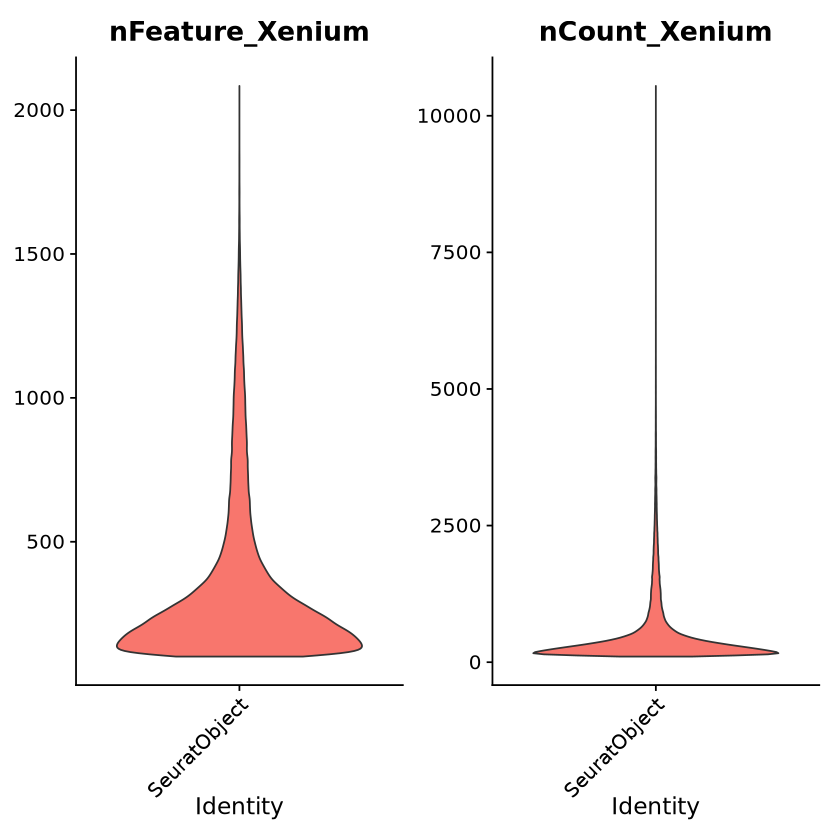

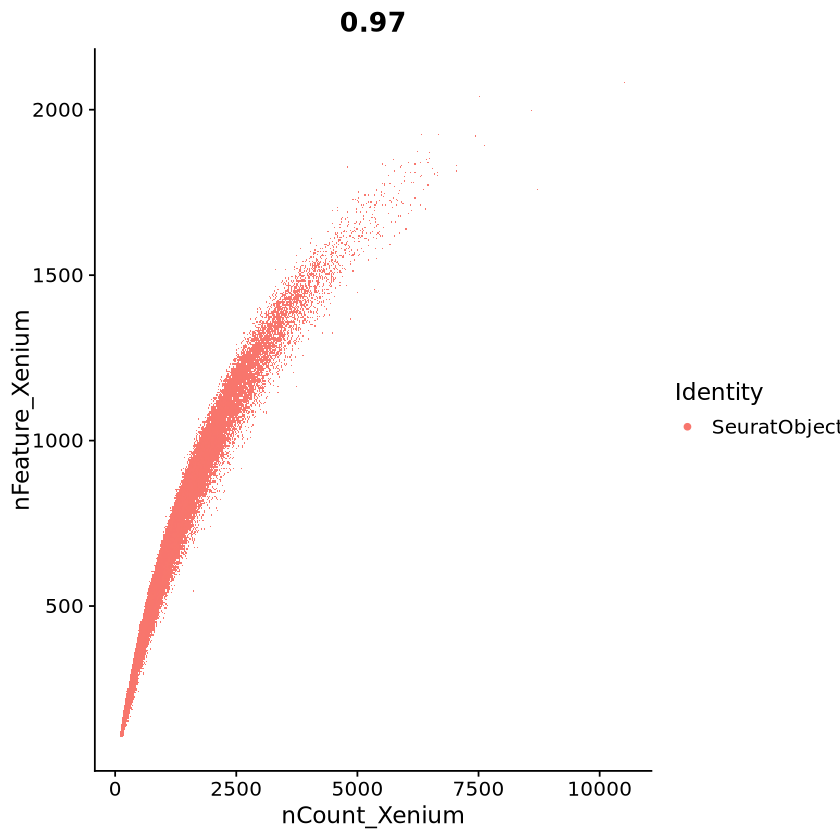

In [4]:
print("Summary of uniqueRNA")
print(summary(obj$nFeature_Xenium))
print("Summary of counts")
print(summary(obj$nCount_Xenium))

VlnPlot(obj, features = c("nFeature_Xenium", "nCount_Xenium"), ncol = 2, pt.size = 0)
FeatureScatter(obj, feature1 = "nCount_Xenium", feature2 = "nFeature_Xenium") 

In [5]:
obj

An object of class Seurat 
10002 features across 217111 samples within 2 assays 
Active assay: Xenium (5001 features, 2991 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: spatial, pca, umap
 1 spatial field of view present: fov

Warning message:
“No FOV associated with assay 'Xenium', using global default FOV”


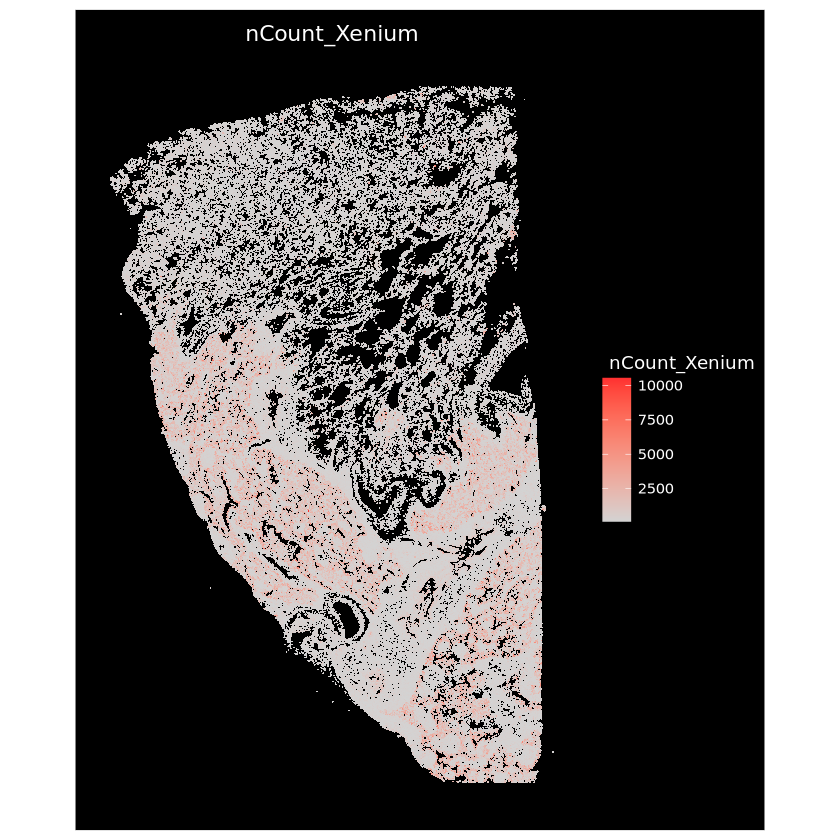

In [6]:
ImageFeaturePlot(obj, features = "nCount_Xenium")

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



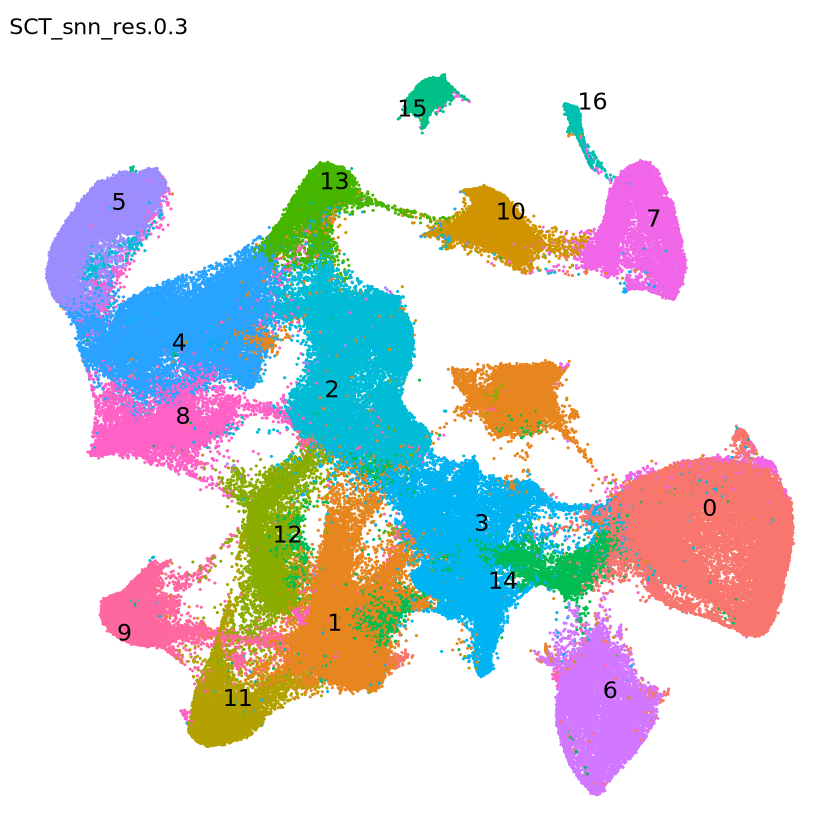

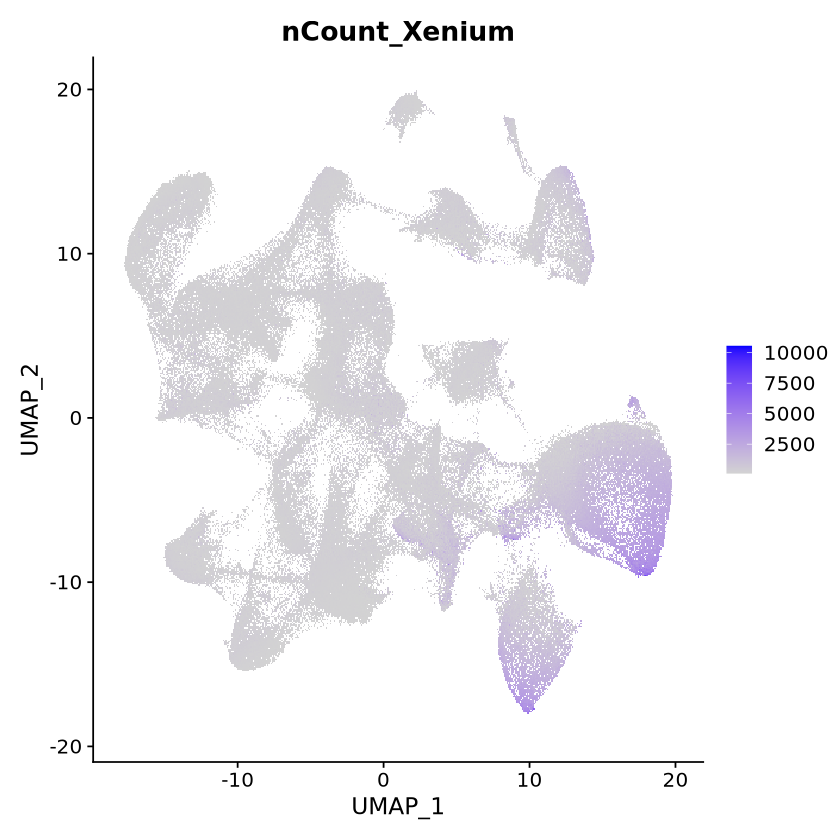

In [11]:
figsize(7, 7)
DimPlot(obj, group.by = "SCT_snn_res.0.3", raster=FALSE, label=TRUE, label.size=5, pt.size = 0.1, repel = TRUE) + theme_void() + NoLegend()
FeaturePlot(obj, features = "nCount_Xenium")

## RCTD: Cell type annotation

In [13]:
library(spacexr)

In [ ]:
query.counts <- GetAssayData(obj, assay = "Xenium", layer = "counts")
coords <- GetTissueCoordinates(obj, which = "centroids")
rownames(coords) <- coords$cell
coords$cell <- NULL
query <- SpatialRNA(coords, query.counts, colSums(query.counts))

In [12]:
annotation <- "CellType_lev2.5_update"
Idents(pancancer_sc) <- annotation
counts <- GetAssayData(pancancer_sc, assay = "RNA", slot = "counts")
cluster <- as.factor(pancancer_sc@meta.data[[annotation]])
names(cluster) <- colnames(pancancer_sc)
nUMI <- pancancer_sc$nCount_RNA
names(nUMI) <- colnames(pancancer_sc)
nUMI <- colSums(counts)
levels(cluster) <- gsub("/", "-", levels(cluster))
reference <- Reference(counts, cluster, nUMI)

Warning message in Reference(counts, cluster, nUMI):
“Reference: missing cell types with no occurences:  Enteric glia, Erythroblast, Erythrocyte, Muscle cell, Oligodendrocytes, Sinusoidal, Doublets, Low quality”
Warning message in Reference(counts, cluster, nUMI):
“Reference: number of cells per cell type is 270757, larger than maximum allowable of 10000. Downsampling number of cells to: 10000”


In [ ]:
# run RCTD with many cores
RCTD <- create.RCTD(query, reference, max_cores = 26)
print("RCTD created, prepared to run")
RCTD <- run.RCTD(RCTD, doublet_mode = "doublet")

saveRDS(RCTD,file = paste0(dir, "/RCTD.rds"))

In [ ]:
RCTD <- readRDS(paste0(dir, "/RCTD.rds"))

results <- RCTD@results
annotations.df <- RCTD@results$results_df
annotations <- annotations.df$first_type
names(annotations) <- rownames(annotations.df)
obj$RCTD.predicted_celltype <- annotations
obj$RCTD.class <- results$results_df$spot_class

keep.cells <- Cells(obj)[!is.na(obj$RCTD.predicted_celltype)]
obj <- subset(obj, cells = keep.cells)

saveRDS(obj, file = paste0(dir, "/xenium5k_obj_RCTD.rds"))

In [ ]:
RCTD <- readRDS(paste0(dir, "/RCTD.rds"))
obj <- readRDS(file = paste0(dir, "/xenium5k_obj_RCTD.rds"))

results <- RCTD@results
# normalize the cell type proportions to sum to 1.
norm_weights = normalize_weights(results$weights) 
cell_type_names <- RCTD@cell_type_info$info[[2]] #list of cell type names
spatialRNA <- RCTD@spatialRNA
resultsdir <- paste0(dir, '/RCTD_Plots') 
dir.create(resultsdir)

Warning message in dir.create(resultsdir):
“'/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC/RCTD_Plots' already exists”


In [19]:
table(results$results_df$spot_class)


           reject           singlet   doublet_certain doublet_uncertain 
            25528            175568             10203              5811 

In [ ]:
# Plots the confident weights for each cell type as in full_mode (saved as 
# 'results/cell_type_weights_unthreshold.pdf')
plot_weights(cell_type_names, spatialRNA, resultsdir, norm_weights) 
# Plots all weights for each cell type as in full_mode. (saved as 
# 'results/cell_type_weights.pdf')
plot_weights_unthreshold(cell_type_names, spatialRNA, resultsdir, norm_weights) 
# Plots the weights for each cell type as in doublet_mode. (saved as 
# 'results/cell_type_weights_doublets.pdf')
plot_weights_doublet(cell_type_names, spatialRNA, resultsdir, results$weights_doublet, 
                     results$results_df) 
# Plots the number of confident pixels of each cell type in 'full_mode'. (saved as 
# 'results/cell_type_occur.pdf')
plot_cond_occur(cell_type_names, resultsdir, norm_weights, spatialRNA) +
    theme(axis.text.x = element_text(angle = 60, hjust = 1))

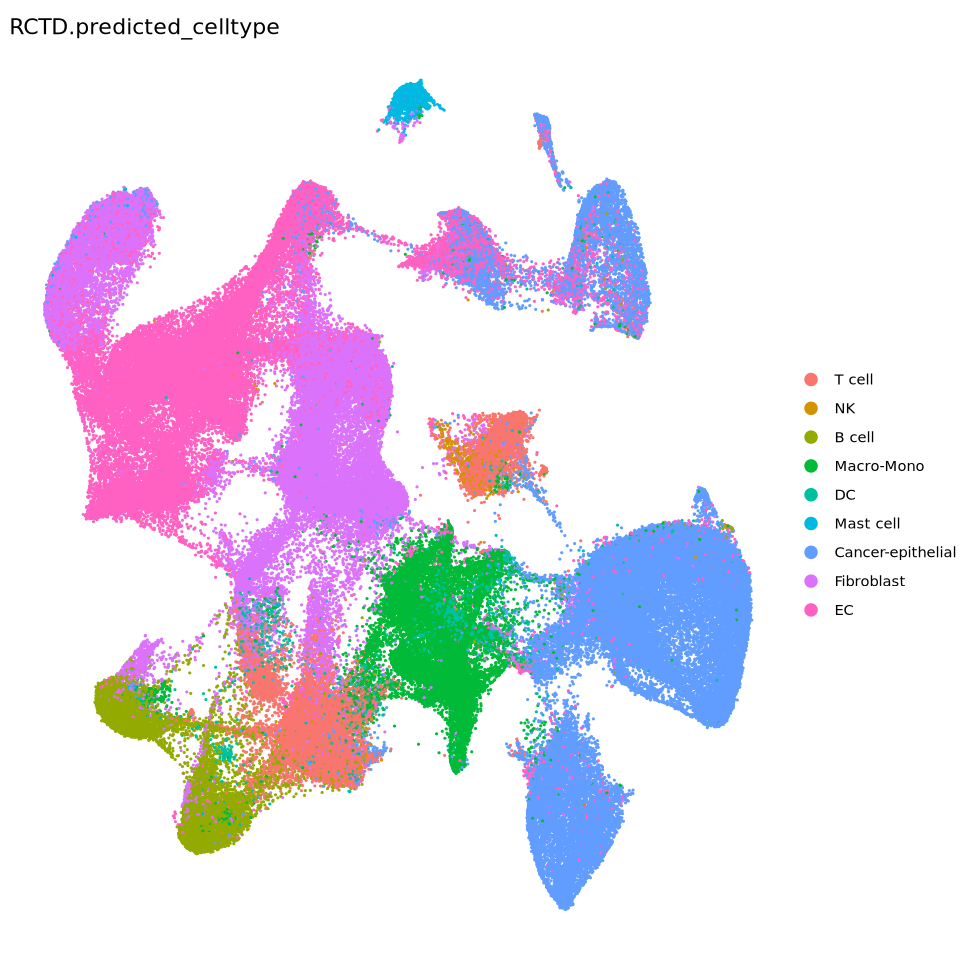

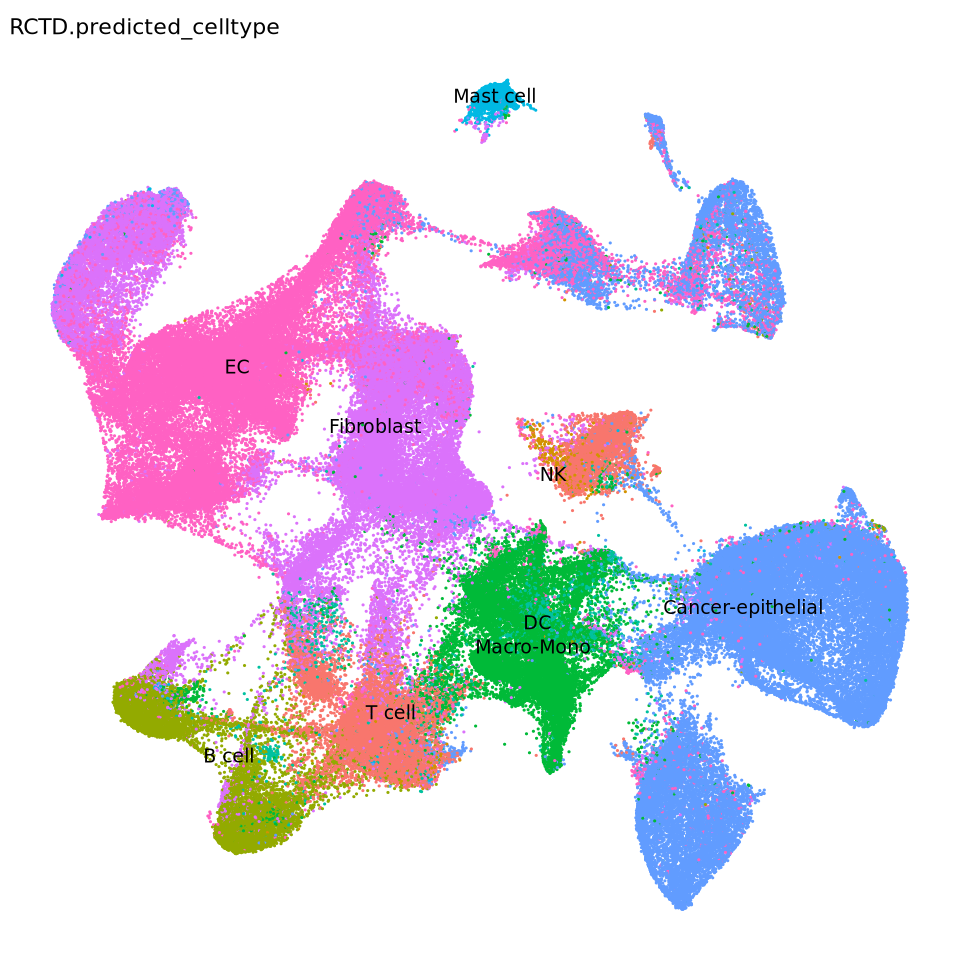

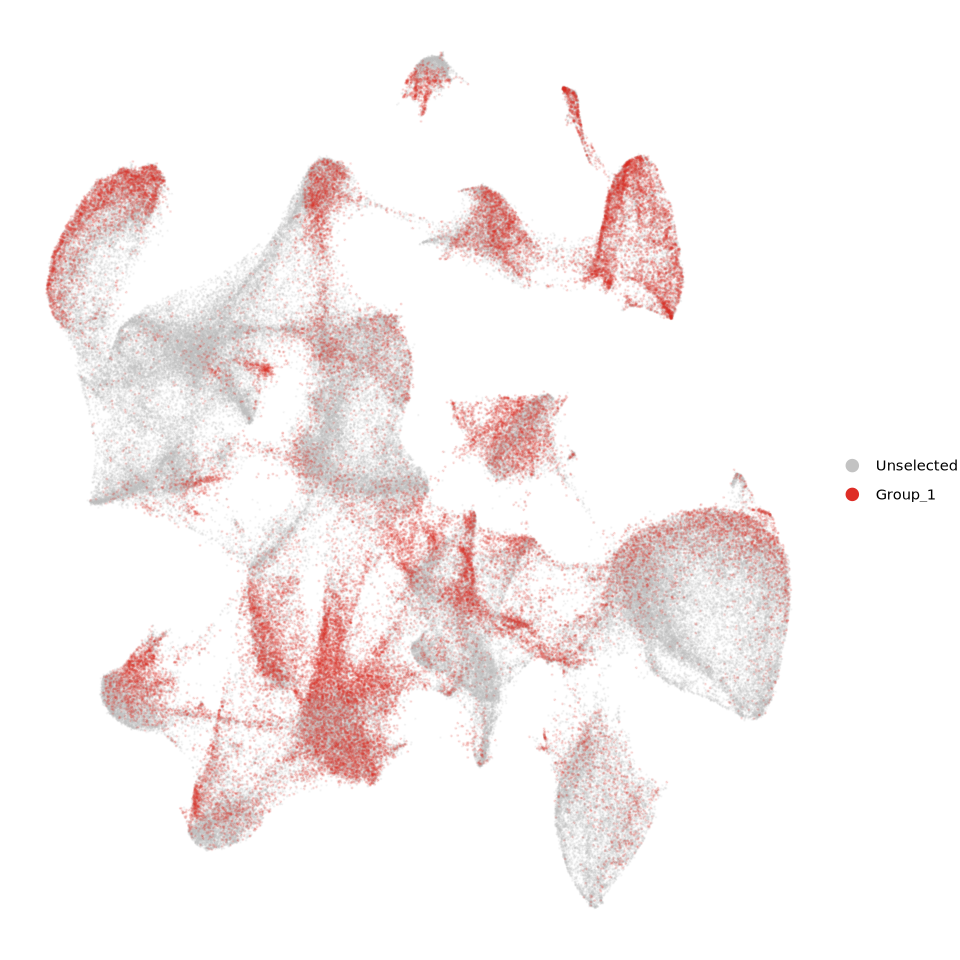

In [20]:
# DimPlot(obj, reduction = "umap", group.by = "RCTD.predicted_celltype", repel = TRUE, raster=FALSE, label=TRUE, label.size=6, pt.size = 0.1) + theme_void()

figsize(8, 8)

# Plot UMAP (with singlets only)
cells_singlets <- Cells(obj)[obj$RCTD.class == "singlet"]
DimPlot(obj, reduction = "umap", group.by = "RCTD.predicted_celltype", cells = cells_singlets, raster=FALSE, label=FALSE, pt.size = 0.1) + theme_void()
DimPlot(obj, reduction = "umap", group.by = "RCTD.predicted_celltype", cells = cells_singlets, raster=FALSE, label=TRUE, label.size=4, pt.size = 0.1) + theme_void() + NoLegend()

# Plot UMAP highlighting doublets
cells_doublets <- Cells(obj)[obj$RCTD.class != "singlet"]
DimPlot(obj, reduction = "umap", cells.highlight = cells_doublets, repel = TRUE, raster=FALSE, label=FALSE, sizes.highlight = 0.1, alpha = 0.1) + theme_void()

# # Plot UMAP
# DimPlot(obj, reduction = "umap", group.by = "RCTD.predicted_celltype", split.by = "RCTD.predicted_celltype", cells = cells_singlets, raster=FALSE, label=FALSE, pt.size = 0.1, ncol = 3) + 
#         theme_void() + 
#         theme(legend.position="none")

Warning message in melt.default(as.matrix(doub_chart)):
“The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(as.matrix(doub_chart)). In the next version, this warning will become an error.”


Joining with `by = join_by(Celltype)`


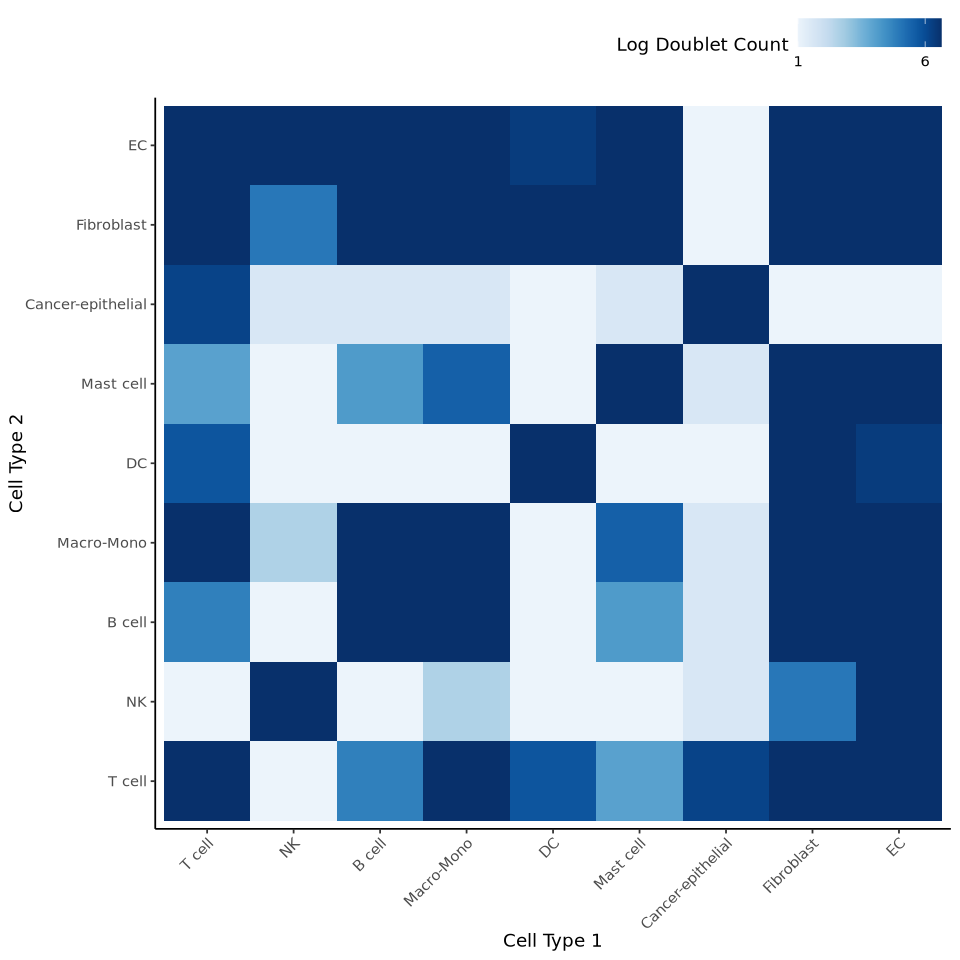

Joining with `by = join_by(Celltype)`


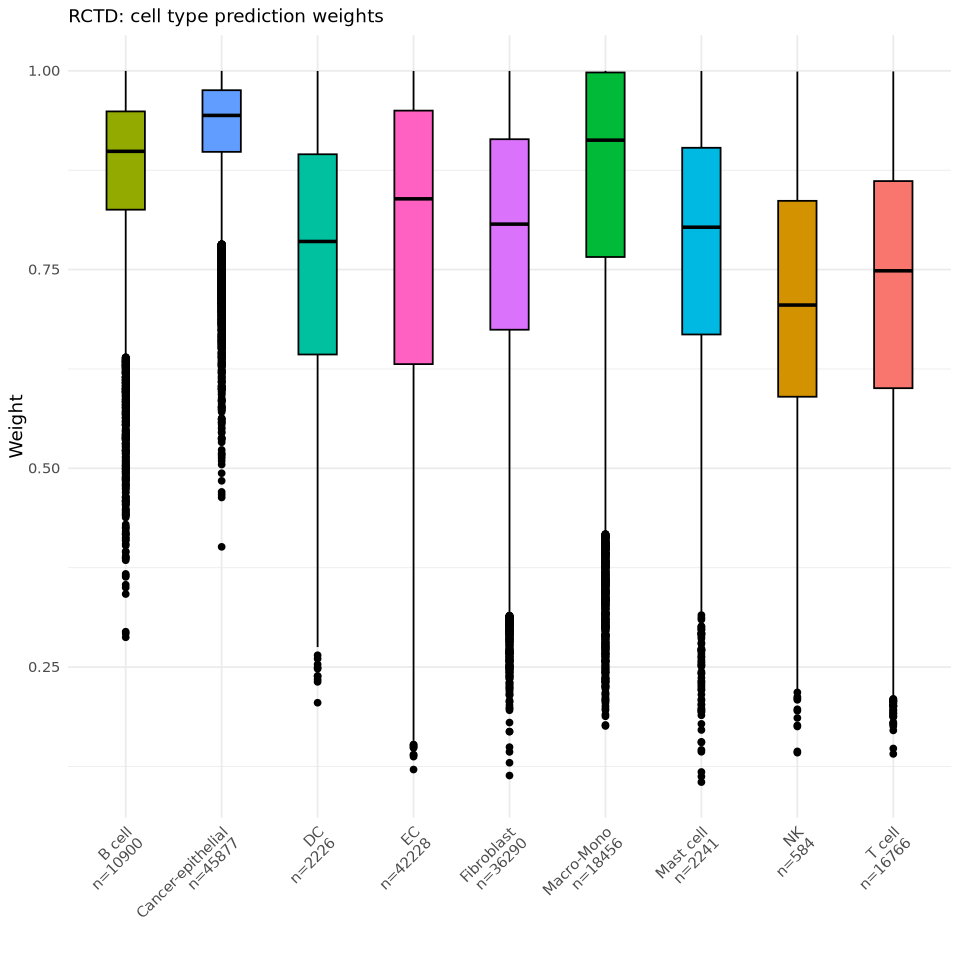

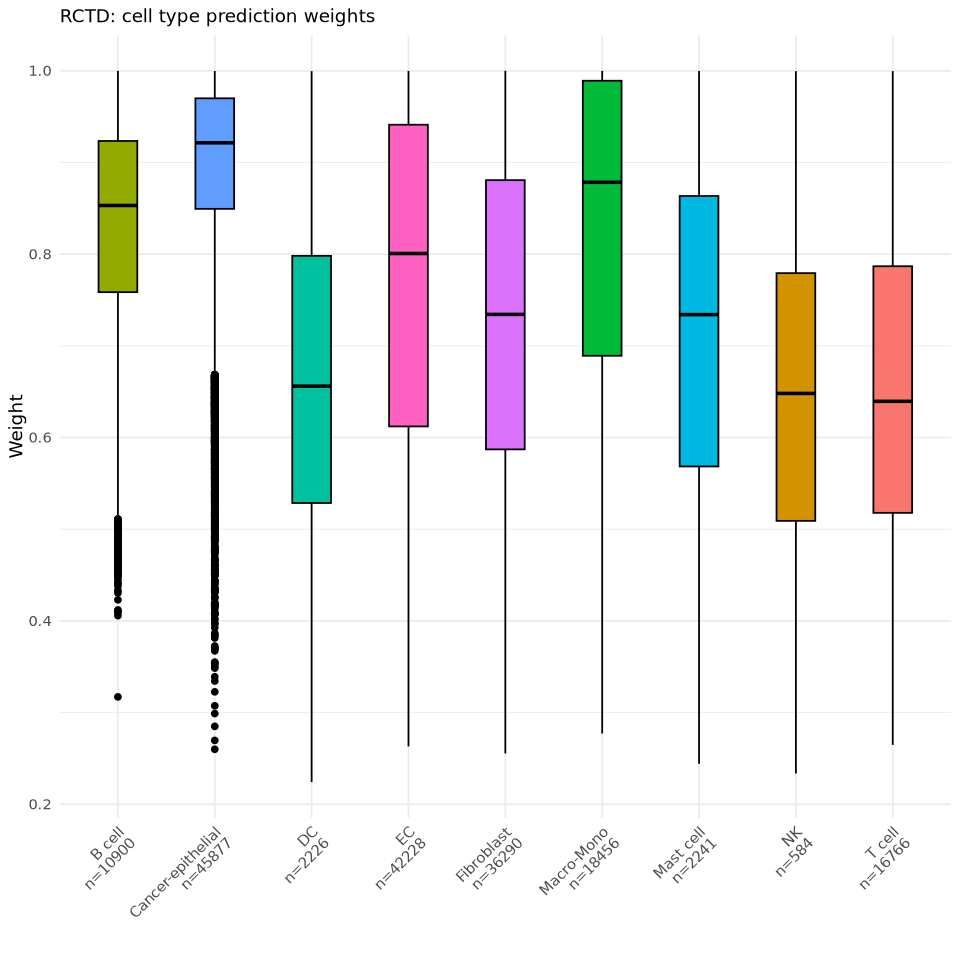

In [21]:
# Heatmap for doublet frequency
# RCTD's classification in doublet mode: "singlet" (1 cell type on pixel), "doublet_certain" (2 cell types on pixel), 
# "doublet_uncertain" (2 cell types on pixel, but only confident of 1), "reject" (no prediction given for pixel)

# pdf(file = paste0(dir, "/RCTD_Plots/doublet_heatmap.pdf"))
doublets <- results$results_df[results$results_df$spot_class == "doublet_certain",]
doub_occur <- table(doublets$second_type, doublets$first_type)
doub_chart <- doub_occur[cell_type_names, cell_type_names]
diag(doub_chart) <- 0.5 * table(results$results_df[results$results_df$spot_class == "singlet","first_type"])[cell_type_names]
doub_chart <- doub_chart + t(doub_chart)
doub_chart <- log(doub_chart,2)
doub_chart[doub_chart < 1] <- 1
doub_chart[doub_chart > log(100,2)] <- log(100,2)
data <- data.table::melt(as.matrix(doub_chart))
colnames(data) = c('Prediction','Reference','value')
p4 <- ggplot(data, aes(Reference, Prediction, fill= value)) +  
        geom_tile() +
        theme_classic() +
        scale_fill_gradientn(colors = pals::brewer.blues(20)[2:20], name = "Log Doublet Count", labels = c(1,6), breaks = c(1,6)) + 
        theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
        theme(legend.position = "top", legend.justification = "right", legend.title = element_text(hjust = 1)) +  
        xlab('Cell Type 1') + 
        ylab('Cell Type 2')
ggpubr::ggarrange(p4)
# dev.off()


# Boxplot for prediction weight per cell type (doublet mode)
singlets <- results$results_df$spot_class == "singlet"
pl.norm_weights_db <- data.frame(Celltype = results$results_df$first_type[singlets], Weight = results$weights_doublet[singlets,"first_type"])

sample_size = pl.norm_weights_db %>% group_by(Celltype) %>% summarize(num=n())

# pdf(file = paste0(dir, "/RCTD_Plots/boxplot_cell_type_weights_doublet.pdf"))
pl.norm_weights_db %>%
  left_join(sample_size) %>%
  mutate(myaxis = paste0(Celltype, "\n", "n=", num)) %>%
  ggplot( aes(x=myaxis, y=Weight, fill=Celltype)) +
    #geom_violin(width=1.4) +
    geom_boxplot(width=0.4, color="black") +
    theme_minimal() +
    theme(
      legend.position="none",
      plot.title = element_text(size=11),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    ggtitle("RCTD: cell type prediction weights") +
    xlab("")
# dev.off()


# Boxplot for prediction weight per cell type (full mode)
singlets <- results$results_df$spot_class == "singlet"
pl.norm_weights <- data.frame(Celltype = results$results_df$first_type[singlets], Weight = apply(norm_weights, 1, FUN = max)[singlets])

sample_size = pl.norm_weights %>% group_by(Celltype) %>% summarize(num=n())

# pdf(file = paste0(dir, "/RCTD_Plots/boxplot_cell_type_weights.pdf"))
pl.norm_weights %>%
  left_join(sample_size) %>%
  mutate(myaxis = paste0(Celltype, "\n", "n=", num)) %>%
  ggplot( aes(x=myaxis, y=Weight, fill=Celltype)) +
    #geom_violin(width=1.4) +
    geom_boxplot(width=0.4, color="black") +
    theme_minimal() +
    theme(
      legend.position="none",
      plot.title = element_text(size=11),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) +
    ggtitle("RCTD: cell type prediction weights") +
    xlab("")
# dev.off()


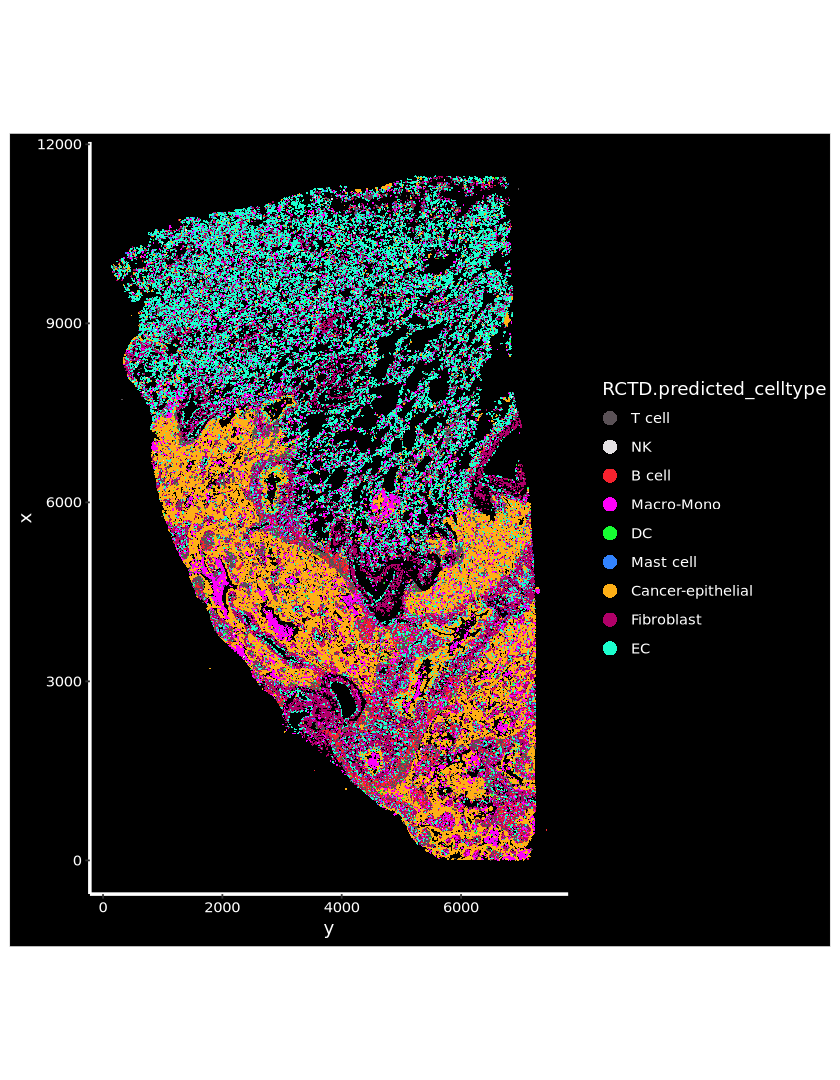

In [23]:
cells_singlets <- Cells(obj)[obj$RCTD.class == "singlet"]
# jpeg(filename = paste0(dir, "/Heesoo_results/spatial_RCTD_predicted_celltype.jpg"), width = 1500, height = 1000)
figsize(7, 9)
ImageDimPlot(obj, cells = cells_singlets, group.by = "RCTD.predicted_celltype", fov = "fov", cols = "polychrome", axes=TRUE)
# dev.off()

In [ ]:
obj_singlets <- subset(obj, subset = RCTD.class == "singlet")
table(obj_singlets$RCTD.class)
saveRDS(obj, file = paste0(dir, "/xenium5k_obj_singlets.rds"))

obj_BC <- subset(obj_singlets, subset = RCTD.predicted_celltype == "B cell")
saveRDS(obj_BC, file = paste0(dir, "/xenium5k_obj_BC.rds"))
obj_TC <- subset(obj_singlets, subset = RCTD.predicted_celltype %in% c("T cell", "NK"))
saveRDS(obj_TC, file = paste0(dir, "/xenium5k_obj_TC.rds"))
obj_DC <- subset(obj_singlets, subset = RCTD.predicted_celltype == "DC")
saveRDS(obj_DC, file = paste0(dir, "/xenium5k_obj_DC.rds"))
obj_EC <- subset(obj_singlets, subset = RCTD.predicted_celltype == "EC")
saveRDS(obj_EC, file = paste0(dir, "/xenium5k_obj_EC.rds"))
obj_MM <- subset(obj_singlets, subset = RCTD.predicted_celltype == "Macro-Mono")
saveRDS(obj_MM, file = paste0(dir, "/xenium5k_obj_MM.rds"))

## Heatmap validation: major cell type signature genes

conda env: single-cell_R-4.0.3

In [4]:
obj_singlets <- readRDS(file = paste0(dir, "/xenium5k_obj_singlets.rds"))

In [8]:
source("/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/Figure_functions.R")
major_marker_genes_list <- list(Tcell = c("CD3D", "CD3E", "TRAC"), NK = c("NCAM1", "KLRC1", "KLRC3", "FGFBP2"), 
                              Bcell = c("CD79A", "CD79B", "MS4A1", "XBP1", "MZB1"), Myeloid = c("LYZ", "CD68", "FCGR3A", "MARCO", "AIF1"),
                              DC = c("LILRA4", "CLEC4C", "GZMB", "CD207", "CD1C", "XCR1", "CLEC9A"), 
                              Neutrophil = c("FCGR3B", "PI3", "G0S2"),
                              Mast = c("KIT", "CTSG", "MS4A2", "TPSAB1", "CPA3"),
                              Epithelial = c("EPCAM", "TP63", "CAV1", "KRT7", "KRT18"), Endothelial = c("PECAM1", "VWF", "CLDN5"), 
                              Fibroblast = c("COL1A1", "COL5A1", "PDGFRB", "ACTA2"))


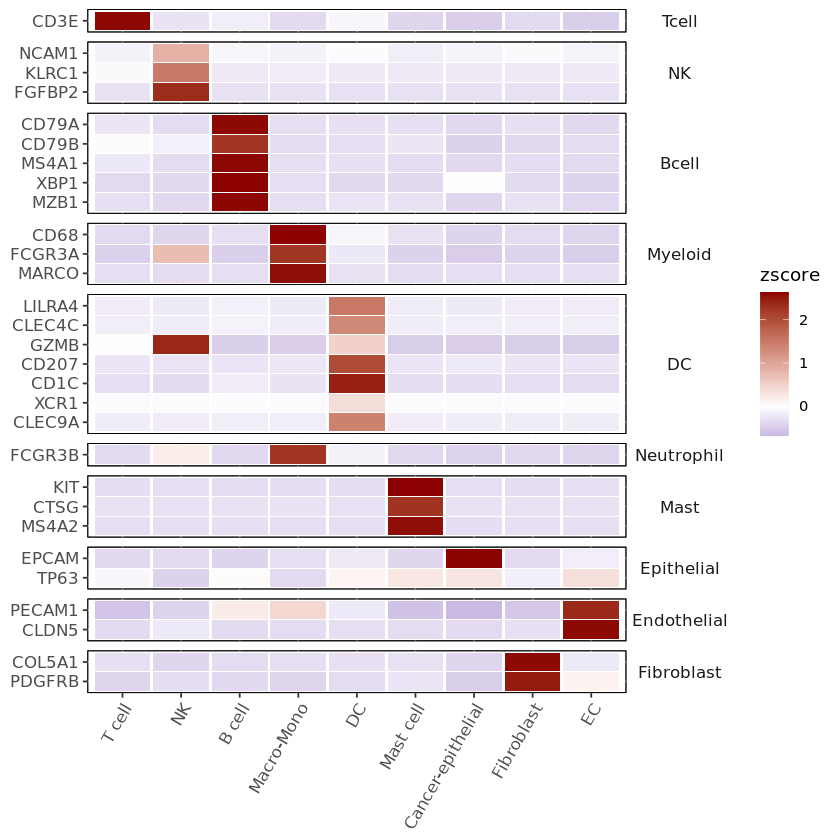

In [9]:
heatmap(obj_singlets, genes = major_marker_genes_list, assay = "Xenium", group.by = "RCTD.predicted_celltype")